In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os

from PIL import Image

# Load Data
Loading from preprocessed numpy array

In [124]:
def load_data(path):
    # TODO: est, train split
    x_train = np.array(pd.read_csv(path).drop([0]).drop(columns=['Date']))
    return x_train
            

def merge_time_series(arr1, arr2) -> tf.float64 :
    t1 = tf.cast(arr1, 'float64') if tf.is_tensor(arr1) else tf.convert_to_tensor(arr1, dtype='float64')
    t2 = tf.cast(arr2, 'float64') if tf.is_tensor(arr2) else tf.convert_to_tensor(arr2, dtype='float64')
    return tf.concat([t1, t2 ], axis=1)

#TODO: support multiple output timesteps
def split_time_series(len_i,len_o, arr) -> (np.array, np.array):
    a = []
    b = []
    for i in range(len(arr)-len_i-len_o):
        a.append(arr[i: i+len_i])
        b.append(arr[i+len_i:i+len_i+len_o])
    return (np.array(a), np.array(b))

def split_time_series(len_i,len_o, arr) -> (np.array, np.array):
    a = []
    b = []
    for i in range(len(arr)-len_i-len_o):
        a.append(arr[i: i+len_i])
        b.append(arr[i+len_i:i+len_i+len_o])
    return (np.array(a), np.array(b))

def split_time_series_disjoint(len_i,len_o, arr) -> (np.array, np.array):
    a = []
    b = []
    for i in range(0, len(arr)-len_i-len_o,  len_o):
        a.append(arr[i: i+len_i])
        b.append(arr[i+len_i:i+len_i+len_o])
    return (np.array(a), np.array(b))

def flatten(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) in (list, np.ndarray, tf.Tensor):
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

(input, output) = split_time_series(5, 5, load_data("./data_stock/SP500_average.csv"))
(djt_input, djt_output) = split_time_series_disjoint(5, 5, load_data("./data_stock/SP500_average.csv"))
print(f'input shape, {input.shape}, output shape, {output.shape}')
merged = merge_time_series(input, output)
print("input",input)
print("output", output)
print("djt_input",djt_input)
print("djt_input", djt_output)
print("merged",merged)
print("flattened input", flatten(input))

def batch_standardize(input):
    def standardize_fn(i) : 
        scaler = StandardScaler();
        scaler.fit(i)
        return (scaler.transform(i), scaler)
    return zip(*[ standardize_fn (i) for i in input])

# scalers require 2D arrays, so add artifically add a dimension when the input is 1D
def batch_scale(input, scalers):
    scale = lambda x,s : s.transform(x) if(len(x.shape)==2) else s.transform([x])[0]
    return list(map(scale, input, scalers))

def batch_inverse_scale(input, scalers):
    scale = lambda x,s : s.inverse_transform(x) if(len(x.shape)==2) else s.inverse_transform([x])[0]
    return list(map(scale, input, scalers))
                                

input shape, (461, 5, 4), output shape, (461, 5, 4)
input [[[4366.64 4411.01 4287.11 4356.45]
  [4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]]

 [[4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]]

 [[4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]
  [4637.99 4665.13 4614.75 4662.85]]

 ...

 [[2498.08 2522.75 2447.49 2470.5 ]
  [2614.69 2641.39 2571.15 2584.59]
  [2558.98 2631.8  2545.28 2626.65]
  [2555.87 2615.91 2520.02 2541.47]
  [2501.29 2637.01 2500.72 2630.07]]

 [[2614.69 2641.39 2571.15 2584.59]
  [2558.98 2631.8  2545.28 2626.65]
  [2555.87 2615.91 2520.02 2541.47]
  [2501.29 2637.01 2500.72 2630.07]
  [2457.77 2571.42 2407.53 2475.56]]

 [[2558.98 2631.8  2545.28

# Creating GAN

In [76]:
class LSTMGAN():
    def __init__(self, step_i, step_o, f, data):
        self.data = data
        self.step_input = step_i
        self.step_output = step_o
        self.feature_len = f
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50):
    

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.step_input, self.step_output, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_scale(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)
            print("input:\n", scalers[0].inverse_transform( real_input[0]))
            print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
            print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)



            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [86]:
data = load_data("./data_stock/SP500_average.csv")
lstmgan = LSTMGAN(5, 5, 4, data)
lstmgan.train(epochs=1000, batch_size=50, save_interval=100)

input:
 [[4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]
 [4206.05 4233.45 4206.05 4229.89]
 [4191.43 4204.39 4167.93 4192.85]
 [4206.82 4217.37 4198.27 4208.12]]
fake_output:
 [[4213.6953 4224.983  4199.419  4216.88  ]
 [4213.739  4224.9355 4199.1577 4216.7983]
 [4213.362  4224.8037 4199.1606 4217.0107]
 [4213.5527 4224.8657 4199.4126 4216.974 ]
 [4213.5586 4224.8076 4199.16   4217.0312]]
real_output:
 [[4216.52 4234.12 4197.59 4202.04]
 [4210.77 4218.36 4203.57 4204.11]
 [4201.94 4213.38 4197.78 4200.88]
 [4191.59 4202.61 4184.11 4195.99]
 [4205.94 4213.42 4182.52 4188.13]]
0 [D loss: 7.624381, acc.: 50.00%] [G loss: 14.945278]
input:
 [[2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]
 [2815.01 2844.24 2797.85 2842.74]
 [2869.09 2869.09 2821.61 2830.71]]
fake_output:
 [[2863.3445 2880.9329 2841.5615 2854.0928]
 [2863.378  2881.428  2842.087  2854.0044]
 [2862.9744 2880.128  2842.0303 2854.3083]
 [2862.9124 28

input:
 [[3131.   3153.45 3076.06 3124.74]
 [2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]]
fake_output:
 [[3106.028  3132.6377 3043.4934 3084.0461]
 [3108.2847 3132.8887 3039.8362 3085.2568]
 [3105.0598 3133.4434 3038.3599 3086.0354]
 [3105.703  3131.7234 3038.4365 3084.1633]
 [3102.7542 3131.471  3039.362  3085.052 ]]
real_output:
 [[3213.32 3222.71 3193.11 3207.18]
 [3199.92 3233.13 3196.   3232.39]
 [3163.84 3211.72 3163.84 3193.93]
 [3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]]
13 [D loss: 0.863004, acc.: 56.20%] [G loss: 6.935674]
input:
 [[4362.41 4385.57 4355.08 4359.46]
 [4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]
 [4406.75 4465.4  4406.75 4448.98]]
fake_output:
 [[4413.928  4437.281  4394.589  4411.5474]
 [4414.187  4437.7383 4393.898  4412.494 ]
 [4413.866  4436.667  4393.932  4412.472 ]
 [4413.083  44

input:
 [[3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]
 [3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]]
fake_output:
 [[3488.2236 3502.7166 3425.2292 3460.1897]
 [3488.16   3504.134  3421.0105 3463.2131]
 [3485.2478 3500.655  3419.3113 3464.6145]
 [3483.3809 3497.7122 3420.6306 3460.2637]
 [3480.0874 3494.311  3419.9375 3459.7837]]
real_output:
 [[3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]]
26 [D loss: 0.564281, acc.: 67.50%] [G loss: 6.171434]
input:
 [[3418.09 3432.09 3413.13 3431.28]
 [3386.01 3399.96 3379.31 3397.16]
 [3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]]
fake_output:
 [[3388.356  3402.3699 3376.7832 3394.6704]
 [3389.4055 3402.5078 3375.8516 3395.379 ]
 [3388.1345 3402.4187 3374.7556 3396.5146]
 [3387.9517 34

input:
 [[4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]
 [4795.49 4807.02 4780.04 4786.35]]
fake_output:
 [[4783.388  4796.9766 4769.5444 4778.961 ]
 [4785.465  4796.271  4767.447  4780.607 ]
 [4782.7285 4795.6187 4767.545  4781.871 ]
 [4782.591  4793.4624 4765.006  4780.4614]
 [4779.707  4793.2153 4765.119  4780.895 ]]
real_output:
 [[4733.99 4791.49 4733.99 4791.19]
 [4703.96 4740.74 4703.96 4725.79]
 [4650.36 4697.67 4645.53 4696.56]
 [4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]]
39 [D loss: 0.532703, acc.: 69.30%] [G loss: 7.748740]
input:
 [[4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]]
fake_output:
 [[4783.8096 4795.084  4745.6714 4746.1265]
 [4786.666  4794.2886 4735.5845 4753.5835]
 [4782.374  4792.4487 4736.6104 4759.741 ]
 [4781.21   47

51 [D loss: 0.578883, acc.: 68.40%] [G loss: 5.235220]
input:
 [[3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]]
fake_output:
 [[3471.328  3488.5847 3460.1433 3480.7056]
 [3476.427  3484.6028 3452.357  3483.397 ]
 [3463.5994 3482.5696 3452.0398 3485.7737]
 [3463.5508 3476.9722 3445.2573 3481.3665]
 [3452.3533 3475.773  3444.0981 3483.5913]]
real_output:
 [[3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]
 [3386.01 3399.96 3379.31 3397.16]
 [3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]]
52 [D loss: 0.553547, acc.: 69.50%] [G loss: 6.320845]
input:
 [[3916.48 3955.31 3914.16 3940.59]
 [3913.14 3930.12 3886.75 3913.1 ]
 [3953.5  3969.62 3910.86 3915.46]
 [3949.57 3983.87 3935.74 3974.12]
 [3973.59 3981.04 3953.44 3962.71]]
fake_output:
 [[3919.4656 3937.6267 3898.048  3910.569 ]
 [3923.7253 3932.3135 3886.582  3914.196 ]
 [

64 [D loss: 0.631548, acc.: 61.20%] [G loss: 5.087462]
input:
 [[2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]
 [2810.42 2844.9  2794.26 2797.8 ]
 [2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]]
fake_output:
 [[2787.606  2798.4763 2743.532  2762.1145]
 [2793.02   2786.5312 2736.246  2760.815 ]
 [2779.7761 2786.9763 2730.714  2759.727 ]
 [2783.2869 2773.7014 2726.3848 2750.862 ]
 [2768.3823 2778.1975 2718.4116 2756.935 ]]
real_output:
 [[2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]
 [2805.1  2851.85 2805.1  2846.06]]
65 [D loss: 0.535735, acc.: 71.10%] [G loss: 5.648442]
input:
 [[3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]]
fake_output:
 [[3870.3928 3899.6665 3833.5728 3881.362 ]
 [3869.4749 3896.701  3821.1538 3880.6538]
 [

77 [D loss: 0.580288, acc.: 66.70%] [G loss: 4.967558]
input:
 [[4220.37 4232.29 4196.05 4221.86]
 [4248.87 4251.89 4202.45 4223.7 ]
 [4255.28 4257.16 4238.35 4246.59]
 [4248.31 4255.59 4234.07 4255.15]
 [4242.9  4248.38 4232.25 4247.44]]
fake_output:
 [[4237.075  4243.2485 4209.7812 4231.333 ]
 [4237.1836 4241.3794 4206.0664 4230.367 ]
 [4233.898  4241.22   4203.522  4229.355 ]
 [4233.6357 4239.377  4202.1846 4227.9775]
 [4230.0005 4239.382  4200.609  4228.3784]]
real_output:
 [[4228.56 4249.74 4220.34 4239.18]
 [4232.99 4237.09 4218.74 4219.55]
 [4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]
 [4206.05 4233.45 4206.05 4229.89]]
78 [D loss: 0.621220, acc.: 59.90%] [G loss: 3.593377]
input:
 [[3403.15 3409.51 3388.71 3390.68]
 [3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]]
fake_output:
 [[3429.2148 3436.2993 3395.089  3415.648 ]
 [3427.622  3432.785  3387.4695 3412.9902]
 [

90 [D loss: 0.515868, acc.: 72.90%] [G loss: 6.513586]
input:
 [[3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]
 [3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]]
fake_output:
 [[3026.5754 3036.3445 2993.7285 3022.9768]
 [3014.3542 3027.1145 2975.9517 3012.9712]
 [3009.2917 3019.4707 2967.9456 3006.3977]
 [2999.232  3012.8267 2958.2004 2998.4314]
 [2992.2    3005.9758 2950.9924 2993.1208]]
real_output:
 [[3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]
 [2948.05 2956.76 2933.59 2955.45]
 [2969.95 2978.5  2938.57 2948.51]
 [2953.63 2980.29 2953.63 2971.61]]
91 [D loss: 0.556837, acc.: 70.50%] [G loss: 4.415230]
input:
 [[3434.28 3447.28 3428.15 3446.83]
 [3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]]
fake_output:
 [[3371.1074 3400.2183 3352.3862 3378.0337]
 [3366.888  3394.8853 3342.1868 3373.3965]
 [

103 [D loss: 0.577173, acc.: 66.60%] [G loss: 6.700784]
input:
 [[4693.39 4725.01 4671.26 4696.05]
 [4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]]
fake_output:
 [[4730.8823 4741.3896 4688.942  4701.729 ]
 [4706.5146 4734.1475 4660.349  4687.853 ]
 [4703.02   4723.8984 4651.192  4678.391 ]
 [4681.0713 4720.255  4636.604  4665.5703]
 [4678.5654 4704.8467 4632.3535 4655.402 ]]
real_output:
 [[4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]
 [4795.49 4807.02 4780.04 4786.35]
 [4733.99 4791.49 4733.99 4791.19]
 [4703.96 4740.74 4703.96 4725.79]]
104 [D loss: 0.533122, acc.: 71.80%] [G loss: 4.930892]
input:
 [[3224.29 3258.61 3215.16 3251.84]
 [3224.21 3233.52 3205.65 3224.73]
 [3208.36 3220.39 3198.59 3215.57]
 [3225.98 3238.28 3200.76 3226.56]
 [3141.11 3200.95 3127.66 3197.52]]
fake_output:
 [[3182.0107 3213.8857 3161.488  3210.2668]
 [3179.666  3207.7935 3152.56   3207.4727]


116 [D loss: 0.517262, acc.: 73.70%] [G loss: 5.837761]
input:
 [[3920.78 3931.5  3884.94 3909.88]
 [3910.49 3918.35 3902.64 3911.23]
 [3892.59 3915.77 3892.59 3915.59]
 [3878.3  3894.56 3874.93 3886.83]
 [3836.66 3872.42 3836.66 3871.74]]
fake_output:
 [[3861.9644 3888.6238 3852.0586 3884.5652]
 [3866.4229 3878.701  3849.536  3880.867 ]
 [3848.8154 3878.0735 3842.0862 3877.3098]
 [3853.0952 3870.0186 3842.9421 3874.1177]
 [3834.1006 3874.447  3835.3206 3874.7683]]
real_output:
 [[3840.27 3847.51 3816.68 3830.17]
 [3791.84 3843.09 3791.84 3826.31]
 [3731.17 3784.32 3725.62 3773.86]
 [3778.05 3778.05 3694.12 3714.24]
 [3755.75 3830.5  3755.75 3787.38]]
117 [D loss: 0.536558, acc.: 70.20%] [G loss: 4.583236]
input:
 [[2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]
 [2805.1  2851.85 2805.1  2846.06]
 [2782.46 2782.46 2721.17 2761.63]
 [2776.99 2818.57 2762.36 2789.82]]
fake_output:
 [[2777.5767 2780.906  2717.1282 2758.4514]
 [2777.7068 2766.611  2711.6875 2747.32  ]


129 [D loss: 0.563036, acc.: 67.20%] [G loss: 4.280664]
input:
 [[3764.71 3811.55 3764.71 3803.79]
 [3712.2  3783.04 3705.34 3748.14]
 [3698.02 3737.83 3695.07 3726.86]
 [3764.61 3769.99 3662.71 3700.65]
 [3733.27 3760.2  3726.88 3756.07]]
fake_output:
 [[3693.166  3733.5017 3648.1943 3693.2424]
 [3690.5132 3720.135  3634.782  3676.0063]
 [3671.854  3712.6218 3620.8323 3667.664 ]
 [3670.8123 3703.9749 3615.0056 3656.5127]
 [3654.6304 3703.1423 3597.455  3653.433 ]]
real_output:
 [[3736.19 3744.63 3730.21 3732.04]
 [3750.01 3756.12 3723.31 3727.04]
 [3723.03 3740.51 3723.03 3735.36]
 [3694.03 3703.82 3689.32 3703.06]
 [3693.42 3711.24 3689.28 3690.01]]
130 [D loss: 0.526611, acc.: 70.30%] [G loss: 6.334094]
input:
 [[4170.46 4179.57 4123.69 4134.98]
 [4128.42 4175.02 4126.35 4173.42]
 [4159.18 4159.18 4118.38 4134.94]
 [4179.8  4180.81 4150.47 4163.26]
 [4174.14 4191.31 4170.75 4185.47]]
fake_output:
 [[4139.9478 4159.4556 4110.932  4128.355 ]
 [4127.4917 4157.3037 4094.3462 4120.1006]


142 [D loss: 0.486831, acc.: 73.00%] [G loss: 6.607646]
input:
 [[4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]
 [4490.45 4501.71 4485.66 4496.19]]
fake_output:
 [[4483.1304 4494.081  4474.3643 4482.5806]
 [4472.632  4492.7017 4459.923  4477.717 ]
 [4469.8843 4486.9756 4454.895  4472.4297]
 [4458.939  4486.6396 4450.249  4465.9824]
 [4460.618  4476.462  4448.8833 4462.189 ]]
real_output:
 [[4484.4  4492.81 4482.28 4486.23]
 [4450.29 4489.88 4450.29 4479.53]
 [4410.56 4444.35 4406.8  4441.67]
 [4382.44 4418.61 4367.73 4405.8 ]
 [4440.94 4454.32 4397.59 4400.27]]
143 [D loss: 0.522921, acc.: 71.00%] [G loss: 5.579681]
input:
 [[4708.44 4717.75 4694.22 4697.96]
 [4700.72 4708.8  4672.78 4704.54]
 [4701.5  4701.5  4684.41 4688.67]
 [4679.42 4714.95 4679.42 4700.9 ]
 [4689.3  4697.42 4672.86 4682.8 ]]
fake_output:
 [[4683.935  4695.1084 4670.2734 4683.688 ]
 [4677.5796 4693.9824 4663.9927 4681.01  ]


155 [D loss: 0.485532, acc.: 76.00%] [G loss: 5.463092]
input:
 [[2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]
 [2810.42 2844.9  2794.26 2797.8 ]
 [2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]]
fake_output:
 [[2769.765  2777.6843 2709.6465 2726.9297]
 [2771.9849 2758.6082 2702.1438 2711.3555]
 [2750.4685 2749.2627 2684.8623 2698.7815]
 [2753.3901 2733.976  2682.1482 2682.3198]
 [2737.211  2739.721  2660.8865 2683.0364]]
real_output:
 [[2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]
 [2805.1  2851.85 2805.1  2846.06]]
156 [D loss: 0.532188, acc.: 70.60%] [G loss: 4.389577]
input:
 [[3566.82 3589.81 3552.77 3577.59]
 [3579.31 3581.23 3556.85 3557.54]
 [3559.41 3585.22 3543.84 3581.87]
 [3612.09 3619.09 3567.33 3567.79]
 [3610.31 3623.11 3588.68 3609.53]]
fake_output:
 [[3577.9436 3586.4854 3559.5798 3571.1018]
 [3568.2214 3588.373  3549.222  3569.4463]


168 [D loss: 0.439431, acc.: 78.60%] [G loss: 8.129382]
input:
 [[3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]
 [3839.66 3861.08 3789.54 3811.15]
 [3915.8  3925.02 3814.04 3829.34]]
fake_output:
 [[3861.9033 3877.8154 3822.8032 3830.8499]
 [3846.739  3879.5708 3802.647  3826.523 ]
 [3847.6074 3875.0615 3800.0093 3822.4548]
 [3830.7097 3875.586  3795.851  3815.989 ]
 [3841.3418 3859.558  3798.207  3810.0159]]
real_output:
 [[3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]]
169 [D loss: 0.462875, acc.: 78.30%] [G loss: 4.310481]
input:
 [[4150.34 4162.04 4111.53 4152.1 ]
 [4228.29 4236.39 4188.13 4188.43]
 [4210.34 4238.04 4201.64 4232.6 ]
 [4169.14 4202.7  4147.33 4201.62]
 [4177.06 4187.72 4160.94 4167.59]]
fake_output:
 [[4156.107  4163.5977 4126.759  4152.85  ]
 [4145.8657 4157.852  4105.7783 4145.6895]


input:
 [[3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]
 [3341.21 3393.56 3340.47 3363.  ]
 [3350.92 3357.92 3327.54 3335.47]]
fake_output:
 [[3348.777  3376.1086 3334.1199 3354.7424]
 [3349.2075 3371.8943 3331.0437 3352.0488]
 [3342.3452 3369.624  3327.8818 3349.1702]
 [3342.981  3366.1274 3328.67   3344.4214]
 [3338.537  3366.676  3325.8335 3344.919 ]]
real_output:
 [[3333.9  3360.74 3332.91 3351.6 ]
 [3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]
 [3320.11 3323.35 3232.57 3236.92]
 [3295.75 3320.31 3270.95 3315.57]]
182 [D loss: 0.537343, acc.: 71.00%] [G loss: 5.015880]
input:
 [[4446.08 4461.77 4435.96 4460.83]
 [4442.18 4449.44 4436.42 4447.7 ]
 [4435.79 4445.21 4430.03 4436.75]
 [4437.77 4439.39 4424.74 4432.35]
 [4429.07 4440.82 4429.07 4436.52]]
fake_output:
 [[4424.615  4430.3394 4420.2163 4418.025 ]
 [4426.0356 4423.4834 4417.4756 4413.0767]
 [4418.5747 4420.368  4415.8003 4410.7144]
 [4420.0195 4

194 [D loss: 0.537086, acc.: 71.90%] [G loss: 3.406130]
input:
 [[2829.95 2865.01 2816.78 2863.7 ]
 [2794.54 2852.8  2766.64 2852.5 ]
 [2865.86 2874.14 2793.15 2820.  ]
 [2939.5  2945.82 2869.59 2870.12]
 [2915.46 2944.25 2903.44 2930.32]]
fake_output:
 [[2757.9004 2813.0718 2713.5527 2781.346 ]
 [2758.3328 2786.0288 2684.3733 2766.9626]
 [2705.157  2774.3962 2667.236  2756.109 ]
 [2719.0298 2751.6433 2659.8433 2743.3123]
 [2688.5532 2760.1858 2632.5378 2743.4111]]
real_output:
 [[2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]
 [2815.01 2844.24 2797.85 2842.74]]
195 [D loss: 0.442945, acc.: 78.80%] [G loss: 4.739637]
input:
 [[2939.5  2945.82 2869.59 2870.12]
 [2915.46 2944.25 2903.44 2930.32]
 [2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]]
fake_output:
 [[2906.7239 2924.071  2884.5315 2898.744 ]
 [2906.7388 2924.2285 2880.161  2897.1262]


207 [D loss: 0.459627, acc.: 78.80%] [G loss: 4.736484]
input:
 [[4642.99 4660.47 4606.52 4634.09]
 [4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]
 [4690.86 4705.06 4674.52 4701.21]]
fake_output:
 [[4671.581  4685.151  4648.723  4664.649 ]
 [4671.0283 4680.8555 4630.8516 4660.6826]
 [4658.037  4678.7764 4629.202  4653.2925]
 [4655.998  4673.8574 4629.1265 4645.806 ]
 [4654.5415 4668.376  4623.2837 4641.84  ]]
real_output:
 [[4631.97 4694.04 4631.97 4686.75]
 [4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]]
208 [D loss: 0.524048, acc.: 76.00%] [G loss: 4.673282]
input:
 [[4733.99 4791.49 4733.99 4791.19]
 [4703.96 4740.74 4703.96 4725.79]
 [4650.36 4697.67 4645.53 4696.56]
 [4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]]
fake_output:
 [[4522.0054 4507.57   4485.1997 4483.2134]
 [4500.542  4485.949  4384.288  4464.205 ]


220 [D loss: 0.549445, acc.: 70.20%] [G loss: 3.273523]
input:
 [[4362.41 4385.57 4355.08 4359.46]
 [4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]
 [4406.75 4465.4  4406.75 4448.98]]
fake_output:
 [[4341.5337 4377.1387 4294.7    4295.5435]
 [4362.444  4343.964  4277.5234 4269.5063]
 [4308.988  4339.015  4272.8823 4269.35  ]
 [4337.0957 4306.954  4266.7773 4242.062 ]
 [4304.641  4329.063  4223.7725 4241.4624]]
real_output:
 [[4367.43 4416.75 4367.43 4395.64]
 [4374.45 4394.87 4347.96 4354.19]
 [4402.95 4402.95 4305.91 4357.73]
 [4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]]
221 [D loss: 0.459040, acc.: 77.50%] [G loss: 5.881407]
input:
 [[4712.   4743.83 4682.17 4682.94]
 [4708.44 4717.75 4694.22 4697.96]
 [4700.72 4708.8  4672.78 4704.54]
 [4701.5  4701.5  4684.41 4688.67]
 [4679.42 4714.95 4679.42 4700.9 ]]
fake_output:
 [[4696.002  4701.4688 4684.0107 4690.675 ]
 [4686.1826 4708.106  4673.3843 4690.005 ]


input:
 [[3270.45 3272.17 3220.26 3271.12]
 [3231.76 3250.92 3204.13 3246.22]
 [3227.22 3264.74 3227.22 3258.44]
 [3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]]
fake_output:
 [[3221.8975 3236.8499 3215.5076 3228.8271]
 [3210.694  3239.7957 3201.969  3226.563 ]
 [3203.7166 3236.19   3202.678  3221.9336]
 [3193.6174 3233.0234 3201.0024 3216.8613]
 [3203.5327 3222.4702 3201.243  3207.616 ]]
real_output:
 [[3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]
 [3254.86 3279.32 3253.1  3276.02]
 [3268.52 3277.29 3247.77 3257.3 ]
 [3224.29 3258.61 3215.16 3251.84]]
234 [D loss: 0.534593, acc.: 76.60%] [G loss: 5.568405]
input:
 [[4293.21 4300.52 4287.04 4291.8 ]
 [4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]
 [4249.27 4256.6  4241.43 4241.84]]
fake_output:
 [[4232.5215 4233.35   4238.7036 4218.733 ]
 [4224.683  4230.719  4206.6904 4213.6562]
 [4203.784  4225.2144 4206.5654 4206.263 ]
 [4204.4937 4

246 [D loss: 0.520990, acc.: 75.10%] [G loss: 4.252177]
input:
 [[4553.69 4572.62 4537.36 4566.48]
 [4546.12 4559.67 4524.   4544.9 ]
 [4532.24 4551.44 4526.89 4549.78]
 [4524.42 4540.87 4524.4  4536.19]
 [4497.34 4520.4  4496.41 4519.63]]
fake_output:
 [[4526.7573 4540.0337 4525.645  4542.5137]
 [4522.664  4543.502  4511.3267 4541.5923]
 [4514.539  4541.14   4512.2905 4539.3706]
 [4507.522  4536.1787 4511.3496 4535.4336]
 [4513.2607 4525.685  4511.858  4528.6987]]
real_output:
 [[4463.72 4488.75 4447.47 4486.46]
 [4447.69 4475.82 4447.69 4471.37]
 [4386.75 4439.73 4386.75 4438.26]
 [4358.01 4372.87 4329.92 4363.8 ]
 [4368.31 4374.89 4342.09 4350.65]]
247 [D loss: 0.515703, acc.: 74.10%] [G loss: 7.588327]
input:
 [[4701.48 4714.92 4694.39 4701.7 ]
 [4699.26 4718.5  4681.32 4697.53]
 [4662.93 4683.   4662.59 4680.06]
 [4630.65 4663.46 4621.19 4660.57]
 [4613.34 4635.15 4613.34 4630.65]]
fake_output:
 [[4564.3887 4598.1797 4573.39   4596.001 ]
 [4583.9077 4578.72   4525.73   4577.4604]


259 [D loss: 0.485758, acc.: 76.30%] [G loss: 4.895690]
input:
 [[4150.34 4162.04 4111.53 4152.1 ]
 [4228.29 4236.39 4188.13 4188.43]
 [4210.34 4238.04 4201.64 4232.6 ]
 [4169.14 4202.7  4147.33 4201.62]
 [4177.06 4187.72 4160.94 4167.59]]
fake_output:
 [[4123.7036 4118.136  4121.094  4117.3115]
 [4119.5474 4125.44   4035.0315 4107.6714]
 [4064.0566 4111.5005 4046.361  4101.3145]
 [4077.5884 4076.7148 4052.3872 4081.0168]
 [4086.1494 4078.4456 4019.5503 4068.663 ]]
real_output:
 [[4179.04 4179.04 4128.59 4164.66]
 [4191.98 4209.39 4188.03 4192.66]
 [4198.1  4198.1  4174.85 4181.17]
 [4206.14 4218.78 4176.81 4211.47]
 [4185.14 4201.53 4181.78 4183.18]]
260 [D loss: 0.512564, acc.: 74.50%] [G loss: 7.005332]
input:
 [[3136.13 3141.16 3108.03 3113.49]
 [3131.   3153.45 3076.06 3124.74]
 [2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]]
fake_output:
 [[2927.6335 3023.231  2891.2415 2914.5867]
 [2954.442  3015.6326 2776.624  2887.7236]


273 [D loss: 0.471338, acc.: 77.60%] [G loss: 5.367333]
input:
 [[4462.12 4462.12 4417.83 4448.08]
 [4461.65 4480.26 4437.66 4479.71]
 [4464.84 4468.37 4460.82 4468.  ]
 [4446.08 4461.77 4435.96 4460.83]
 [4442.18 4449.44 4436.42 4447.7 ]]
fake_output:
 [[4428.8555 4444.864  4399.     4428.6035]
 [4442.319  4435.0176 4387.4688 4418.057 ]
 [4414.045  4435.8794 4390.5576 4425.208 ]
 [4434.0537 4413.6562 4398.448  4411.2637]
 [4419.312  4431.9556 4367.6787 4411.3457]]
real_output:
 [[4435.79 4445.21 4430.03 4436.75]
 [4437.77 4439.39 4424.74 4432.35]
 [4429.07 4440.82 4429.07 4436.52]
 [4408.86 4429.76 4408.86 4429.1 ]
 [4415.95 4416.17 4400.23 4402.66]]
274 [D loss: 0.468755, acc.: 75.80%] [G loss: 6.126405]
input:
 [[3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]
 [3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]]
fake_output:
 [[3392.2104 3452.6624 3372.1934 3403.128 ]
 [3436.6104 3426.6055 3365.1904 3387.4338]


286 [D loss: 0.603482, acc.: 69.40%] [G loss: 4.560683]
input:
 [[3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]
 [3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]]
fake_output:
 [[3473.45   3485.952  3458.089  3464.5383]
 [3466.1824 3496.2346 3434.6213 3463.0786]
 [3452.5144 3489.975  3436.5894 3457.0706]
 [3444.2158 3483.882  3435.4048 3454.8113]
 [3448.742  3468.2793 3441.7568 3445.169 ]]
real_output:
 [[3453.72 3489.08 3440.89 3483.34]
 [3515.47 3527.94 3480.55 3488.67]
 [3534.01 3534.01 3500.86 3511.93]
 [3500.02 3549.85 3499.61 3534.22]
 [3459.67 3482.34 3458.07 3477.13]]
287 [D loss: 0.546372, acc.: 69.80%] [G loss: 4.386755]
input:
 [[2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]]
fake_output:
 [[2751.8594 2735.6309 2726.5256 2706.1606]
 [2758.4055 2749.0234 2632.5598 2693.113 ]


input:
 [[3712.2  3783.04 3705.34 3748.14]
 [3698.02 3737.83 3695.07 3726.86]
 [3764.61 3769.99 3662.71 3700.65]
 [3733.27 3760.2  3726.88 3756.07]
 [3736.19 3744.63 3730.21 3732.04]]
fake_output:
 [[3662.525  3710.478  3649.3604 3676.2004]
 [3678.909  3711.9023 3588.7617 3667.635 ]
 [3613.2773 3707.7483 3596.3152 3672.1143]
 [3649.611  3667.8694 3624.2583 3647.3994]
 [3643.5344 3693.661  3570.0908 3638.0232]]
real_output:
 [[3750.01 3756.12 3723.31 3727.04]
 [3723.03 3740.51 3723.03 3735.36]
 [3694.03 3703.82 3689.32 3703.06]
 [3693.42 3711.24 3689.28 3690.01]
 [3698.08 3698.26 3676.16 3687.26]]
300 [D loss: 0.619630, acc.: 67.00%] [G loss: 4.475530]
input:
 [[3791.84 3843.09 3791.84 3826.31]
 [3731.17 3784.32 3725.62 3773.86]
 [3778.05 3778.05 3694.12 3714.24]
 [3755.75 3830.5  3755.75 3787.38]
 [3836.83 3836.83 3732.48 3750.77]]
fake_output:
 [[3784.373  3793.3716 3775.8667 3782.461 ]
 [3759.301  3819.2515 3710.187  3784.2847]
 [3741.918  3809.3877 3718.0754 3773.4724]
 [3720.791  3

input:
 [[4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]
 [4474.81 4492.99 4445.7  4468.73]
 [4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]]
fake_output:
 [[4460.39   4474.61   4447.341  4451.624 ]
 [4452.6333 4482.3164 4403.301  4450.136 ]
 [4423.995  4476.257  4408.9585 4446.776 ]
 [4427.7744 4457.5127 4420.4443 4433.9736]
 [4438.8867 4456.96   4403.8726 4423.    ]]
real_output:
 [[4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]]
313 [D loss: 0.557219, acc.: 71.40%] [G loss: 3.667732]
input:
 [[3155.29 3182.59 3155.29 3179.72]
 [3143.64 3165.81 3124.52 3130.01]
 [3105.92 3128.44 3101.17 3115.86]
 [3050.2  3111.51 3047.83 3100.29]
 [3018.59 3053.89 2999.74 3053.24]]
fake_output:
 [[2925.2085 3045.329  2926.5276 3004.4385]
 [3017.2854 2981.885  2860.608  2965.4753]
 [2828.735  2993.9036 2866.3447 2987.9702]
 [2959.9817 2

325 [D loss: 0.544357, acc.: 70.00%] [G loss: 3.937968]
input:
 [[3199.92 3233.13 3196.   3232.39]
 [3163.84 3211.72 3163.84 3193.93]
 [3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]]
fake_output:
 [[3077.7432 3096.9329 3083.8525 3094.2373]
 [3083.212  3092.7324 3022.5718 3079.6267]
 [3022.433  3088.127  3021.724  3079.5364]
 [3047.2346 3024.8396 3047.5227 3041.9668]
 [3036.426  3051.576  3001.2888 3026.17  ]]
real_output:
 [[3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]]
326 [D loss: 0.553285, acc.: 70.80%] [G loss: 5.996964]
input:
 [[4572.87 4608.08 4567.59 4605.38]
 [4562.84 4597.55 4562.84 4596.42]
 [4580.22 4584.57 4551.66 4551.68]
 [4578.69 4598.53 4569.17 4574.79]
 [4553.69 4572.62 4537.36 4566.48]]
fake_output:
 [[4565.8423 4591.975  4554.477  4576.0635]
 [4568.8735 4586.8647 4550.0327 4571.531 ]


339 [D loss: 0.600507, acc.: 65.70%] [G loss: 4.516637]
input:
 [[3583.04 3645.99 3547.48 3550.5 ]
 [3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]
 [3336.25 3389.49 3336.25 3369.16]]
fake_output:
 [[3183.2756 3335.5715 3259.107  3292.2285]
 [3298.2173 3239.726  3148.141  3230.8188]
 [3011.671  3264.407  3167.3782 3255.4807]
 [3224.2307 3016.7532 3229.6663 3171.311 ]
 [3105.0818 3206.6218 3011.5137 3157.4907]]
real_output:
 [[3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]]
340 [D loss: 0.586730, acc.: 66.80%] [G loss: 5.655660]
input:
 [[3453.6  3479.15 3349.63 3426.96]
 [3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]]
fake_output:
 [[3475.4272 3543.6448 3378.2083 3460.6677]
 [3528.2405 3490.157  3398.4656 3425.6882]


353 [D loss: 0.655422, acc.: 62.70%] [G loss: 4.967260]
input:
 [[3199.92 3233.13 3196.   3232.39]
 [3163.84 3211.72 3163.84 3193.93]
 [3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]]
fake_output:
 [[3138.3035 3134.4844 3198.8855 3180.8804]
 [3112.0747 3165.8445 3081.4946 3193.7795]
 [3069.8687 3150.7366 3099.226  3169.2656]
 [3044.0444 3112.3677 3093.6133 3136.409 ]
 [3079.4585 3054.4058 3094.8865 3088.237 ]]
real_output:
 [[3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]]
354 [D loss: 0.629602, acc.: 60.30%] [G loss: 3.564728]
input:
 [[3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]
 [3254.86 3279.32 3253.1  3276.02]
 [3268.52 3277.29 3247.77 3257.3 ]
 [3224.29 3258.61 3215.16 3251.84]]
fake_output:
 [[3170.6716 3215.637  3176.424  3183.5374]
 [3204.7512 3190.256  3138.9216 3164.976 ]


input:
 [[4587.9  4587.9  4531.1  4568.02]
 [4652.5  4666.7  4600.22 4620.64]
 [4719.13 4731.99 4651.89 4668.67]
 [4636.46 4712.6  4611.22 4709.85]
 [4642.99 4660.47 4606.52 4634.09]]
fake_output:
 [[4515.278  4602.4478 4496.192  4510.468 ]
 [4601.2217 4499.5425 4465.0547 4451.477 ]
 [4431.09   4517.155  4477.3735 4476.3765]
 [4550.821  4362.4917 4498.4    4416.323 ]
 [4478.646  4511.7754 4366.4365 4415.7627]]
real_output:
 [[4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]
 [4690.86 4705.06 4674.52 4701.21]
 [4631.97 4694.04 4631.97 4686.75]]
367 [D loss: 0.604882, acc.: 66.10%] [G loss: 4.519613]
input:
 [[4130.55 4134.73 4056.88 4063.04]
 [4150.34 4162.04 4111.53 4152.1 ]
 [4228.29 4236.39 4188.13 4188.43]
 [4210.34 4238.04 4201.64 4232.6 ]
 [4169.14 4202.7  4147.33 4201.62]]
fake_output:
 [[4104.8906 4044.4517 4134.512  4020.6587]
 [4076.384  4088.3298 3891.1467 4043.5645]
 [3992.3975 4065.959  3951.7231 4001.2043]
 [4010.065  3

379 [D loss: 0.558206, acc.: 68.30%] [G loss: 9.316245]
input:
 [[3317.37 3330.77 3317.37 3327.77]
 [3289.92 3306.84 3286.37 3306.51]
 [3288.26 3302.73 3284.53 3294.61]
 [3270.45 3272.17 3220.26 3271.12]
 [3231.76 3250.92 3204.13 3246.22]]
fake_output:
 [[3293.1748 3266.4312 3340.5237 3305.9797]
 [3260.6748 3303.2952 3219.081  3319.192 ]
 [3242.3672 3285.7292 3240.0537 3297.624 ]
 [3216.4258 3270.3071 3229.7668 3286.2256]
 [3249.351  3227.9038 3249.6313 3251.486 ]]
real_output:
 [[3227.22 3264.74 3227.22 3258.44]
 [3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]
 [3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]]
380 [D loss: 0.635740, acc.: 64.00%] [G loss: 3.743827]
input:
 [[4242.9  4248.38 4232.25 4247.44]
 [4228.56 4249.74 4220.34 4239.18]
 [4232.99 4237.09 4218.74 4219.55]
 [4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]]
fake_output:
 [[4227.185  4241.6504 4206.3853 4221.631 ]
 [4234.138  4230.8506 4210.0737 4212.579 ]


392 [D loss: 0.637512, acc.: 61.10%] [G loss: 4.331968]
input:
 [[3219.84 3241.43 3214.25 3239.41]
 [3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]
 [3254.86 3279.32 3253.1  3276.02]
 [3268.52 3277.29 3247.77 3257.3 ]]
fake_output:
 [[3189.271  3268.6558 3166.92   3204.6726]
 [3251.171  3203.0637 3187.5122 3166.8127]
 [3158.9526 3211.3335 3190.425  3181.3838]
 [3231.8838 3150.0808 3200.807  3169.7422]
 [3174.4414 3240.1562 3124.873  3176.7354]]
real_output:
 [[3224.29 3258.61 3215.16 3251.84]
 [3224.21 3233.52 3205.65 3224.73]
 [3208.36 3220.39 3198.59 3215.57]
 [3225.98 3238.28 3200.76 3226.56]
 [3141.11 3200.95 3127.66 3197.52]]
393 [D loss: 0.667605, acc.: 60.60%] [G loss: 3.337435]
input:
 [[3406.46 3486.25 3405.17 3443.44]
 [3336.25 3389.49 3336.25 3369.16]
 [3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]]
fake_output:
 [[3328.1658 3290.1458 3372.77   3345.1226]
 [3266.3564 3368.411  3223.6519 3367.566 ]


405 [D loss: 0.586069, acc.: 62.70%] [G loss: 7.994550]
input:
 [[3138.7  3154.9  3127.12 3131.29]
 [3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]
 [3136.13 3141.16 3108.03 3113.49]]
fake_output:
 [[3143.7979 3152.2832 3122.6953 3130.4941]
 [3138.4617 3155.6924 3113.0906 3129.6584]
 [3125.1338 3150.778  3111.833  3126.5366]
 [3117.4385 3145.578  3108.6104 3123.5576]
 [3114.821  3135.0422 3110.0903 3119.49  ]]
real_output:
 [[3131.   3153.45 3076.06 3124.74]
 [2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]]
406 [D loss: 0.586241, acc.: 65.70%] [G loss: 5.171135]
input:
 [[2930.91 2930.91 2892.47 2912.43]
 [2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]
 [2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]]
fake_output:
 [[2773.155  2795.7292 2794.5054 2794.7031]
 [2766.155  2790.9294 2680.7463 2779.7236]


418 [D loss: 0.653990, acc.: 62.60%] [G loss: 4.685335]
input:
 [[4553.69 4572.62 4537.36 4566.48]
 [4546.12 4559.67 4524.   4544.9 ]
 [4532.24 4551.44 4526.89 4549.78]
 [4524.42 4540.87 4524.4  4536.19]
 [4497.34 4520.4  4496.41 4519.63]]
fake_output:
 [[4532.451  4499.957  4560.002  4547.403 ]
 [4483.4644 4545.2417 4481.353  4564.2695]
 [4473.6807 4527.497  4501.153  4540.3726]
 [4446.217  4513.9165 4496.148  4533.4062]
 [4501.519  4472.2856 4506.949  4496.8364]]
real_output:
 [[4463.72 4488.75 4447.47 4486.46]
 [4447.69 4475.82 4447.69 4471.37]
 [4386.75 4439.73 4386.75 4438.26]
 [4358.01 4372.87 4329.92 4363.8 ]
 [4368.31 4374.89 4342.09 4350.65]]
419 [D loss: 0.569285, acc.: 70.30%] [G loss: 4.887183]
input:
 [[3953.5  3969.62 3910.86 3915.46]
 [3949.57 3983.87 3935.74 3974.12]
 [3973.59 3981.04 3953.44 3962.71]
 [3942.96 3970.08 3923.54 3968.94]
 [3924.52 3944.99 3915.21 3943.34]]
fake_output:
 [[3930.5486 3975.7717 3904.7712 3937.5898]
 [3950.952  3950.3833 3908.4236 3914.0332]


432 [D loss: 0.586551, acc.: 67.70%] [G loss: 5.230777]
input:
 [[3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]
 [3320.11 3323.35 3232.57 3236.92]
 [3295.75 3320.31 3270.95 3315.57]
 [3285.57 3285.57 3229.1  3281.06]]
fake_output:
 [[3315.116  3335.1865 3262.3474 3322.5361]
 [3332.05   3320.201  3263.4373 3305.7107]
 [3290.1104 3318.5142 3259.9714 3309.1384]
 [3286.1401 3309.303  3256.9307 3301.2827]
 [3265.4937 3313.1638 3240.4639 3298.1719]]
real_output:
 [[3357.38 3362.27 3292.4  3319.47]
 [3346.86 3375.17 3328.82 3357.01]
 [3411.23 3428.92 3384.45 3385.49]
 [3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]]
433 [D loss: 0.563342, acc.: 66.20%] [G loss: 4.966636]
input:
 [[3563.22 3581.16 3557.   3572.66]
 [3543.26 3557.22 3511.91 3545.53]
 [3583.04 3645.99 3547.48 3550.5 ]
 [3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]]
fake_output:
 [[3465.7375 3582.951  3429.7942 3500.2708]
 [3539.067  3459.81   3459.3274 3456.0095]


445 [D loss: 0.586807, acc.: 66.50%] [G loss: 7.765998]
input:
 [[3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]]
fake_output:
 [[3457.2185 3457.1333 3425.5967 3426.2568]
 [3448.6946 3450.5696 3338.6956 3408.7766]
 [3394.6206 3435.0022 3355.374  3379.0244]
 [3412.6487 3384.5986 3359.7695 3362.294 ]
 [3424.235  3412.1863 3311.3196 3315.2666]]
real_output:
 [[3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]
 [3386.01 3399.96 3379.31 3397.16]]
446 [D loss: 0.638377, acc.: 60.90%] [G loss: 5.071708]
input:
 [[4528.8  4537.11 4522.02 4524.09]
 [4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]]
fake_output:
 [[4519.2104 4518.779  4544.0283 4535.123 ]
 [4500.3853 4531.9155 4491.3003 4542.589 ]


458 [D loss: 0.565083, acc.: 69.80%] [G loss: 4.888652]
input:
 [[3543.26 3557.22 3511.91 3545.53]
 [3583.04 3645.99 3547.48 3550.5 ]
 [3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]]
fake_output:
 [[3498.4202 3407.0525 3622.1243 3536.5525]
 [3362.5806 3547.868  3367.848  3589.8167]
 [3335.7747 3485.5564 3410.5205 3527.787 ]
 [3230.493  3450.4712 3393.4265 3507.9082]
 [3386.6953 3293.991  3444.6135 3419.9639]]
real_output:
 [[3336.25 3389.49 3336.25 3369.16]
 [3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]]
459 [D loss: 0.634172, acc.: 61.40%] [G loss: 4.099941]
input:
 [[3992.78 4020.63 3992.78 4019.87]
 [3967.25 3994.41 3966.98 3972.89]
 [3963.34 3968.01 3944.35 3958.55]
 [3969.31 3981.83 3943.25 3971.09]
 [3917.12 3978.19 3917.12 3974.54]]
fake_output:
 [[3871.5977 3919.3315 3901.7422 3919.0034]
 [3863.7424 3914.4402 3793.826  3912.0315]


input:
 [[3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]]
fake_output:
 [[3001.018  2988.6567 3023.1277 3009.934 ]
 [2974.013  3014.6465 2901.1963 3031.333 ]
 [2956.2678 2998.8938 2923.5938 2997.0837]
 [2940.2344 2980.4558 2926.0117 2988.8906]
 [2974.7466 2956.8083 2931.9775 2939.174 ]]
real_output:
 [[2948.05 2956.76 2933.59 2955.45]
 [2969.95 2978.5  2938.57 2948.51]
 [2953.63 2980.29 2953.63 2971.61]
 [2948.59 2964.21 2922.35 2922.94]
 [2913.86 2968.09 2913.86 2953.91]]
472 [D loss: 0.657497, acc.: 59.70%] [G loss: 3.529696]
input:
 [[4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]
 [4474.81 4492.99 4445.7  4468.73]]
fake_output:
 [[4472.3477 4490.655  4439.63   4468.105 ]
 [4476.615  4485.62   4439.799  4460.6533]
 [4466.431  4484.529  4439.8965 4459.603 ]
 [4467.338  4

484 [D loss: 0.569464, acc.: 68.10%] [G loss: 4.516133]
input:
 [[4138.78 4194.17 4138.78 4180.17]
 [4170.46 4179.57 4123.69 4134.98]
 [4128.42 4175.02 4126.35 4173.42]
 [4159.18 4159.18 4118.38 4134.94]
 [4179.8  4180.81 4150.47 4163.26]]
fake_output:
 [[4113.4634 4171.3857 4099.791  4121.9995]
 [4132.3457 4147.037  4100.1357 4091.8513]
 [4084.941  4146.2275 4099.7383 4091.5723]
 [4111.3877 4125.492  4098.9165 4085.9202]
 [4088.2522 4151.533  4073.8042 4081.4119]]
real_output:
 [[4174.14 4191.31 4170.75 4185.47]
 [4139.76 4173.49 4139.76 4170.42]
 [4141.58 4151.69 4120.87 4124.66]
 [4130.1  4148.   4124.43 4141.59]
 [4124.71 4131.76 4114.82 4127.99]]
485 [D loss: 0.563871, acc.: 68.40%] [G loss: 6.223894]
input:
 [[4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]]
fake_output:
 [[4762.006  4767.14   4766.371  4765.5845]
 [4750.3047 4771.7695 4734.2563 4767.588 ]


497 [D loss: 0.744424, acc.: 53.00%] [G loss: 4.851238]
input:
 [[3205.08 3235.32 3149.43 3155.22]
 [3152.47 3186.82 3136.22 3185.04]
 [3176.17 3179.78 3115.7  3152.05]
 [3153.07 3171.8  3136.53 3169.94]
 [3166.44 3184.15 3142.93 3145.32]]
fake_output:
 [[3176.5796 3228.5623 3134.0864 3166.0408]
 [3195.8896 3189.266  3140.4766 3151.4526]
 [3162.1912 3185.7454 3140.3215 3153.525 ]
 [3171.8347 3166.6091 3140.4175 3152.5623]
 [3155.4653 3197.0115 3121.5789 3154.7393]]
real_output:
 [[3155.29 3182.59 3155.29 3179.72]
 [3143.64 3165.81 3124.52 3130.01]
 [3105.92 3128.44 3101.17 3115.86]
 [3050.2  3111.51 3047.83 3100.29]
 [3018.59 3053.89 2999.74 3053.24]]
498 [D loss: 0.757755, acc.: 54.10%] [G loss: 4.199777]
input:
 [[4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]
 [4529.75 4531.39 4515.8  4522.68]]
fake_output:
 [[4536.7344 4548.98   4527.1113 4540.2715]
 [4537.516  4545.474  4527.5376 4535.649 ]


510 [D loss: 0.629729, acc.: 61.60%] [G loss: 4.881359]
input:
 [[4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]]
fake_output:
 [[4523.323  4508.871  4541.879  4527.588 ]
 [4508.9805 4527.854  4481.9775 4539.896 ]
 [4511.062  4520.63   4485.284  4526.167 ]
 [4498.2046 4519.466  4483.015  4520.5225]
 [4514.388  4497.1436 4502.8306 4500.458 ]]
real_output:
 [[4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]
 [4490.45 4501.71 4485.66 4496.19]]
511 [D loss: 0.662726, acc.: 58.00%] [G loss: 3.676395]
input:
 [[3924.52 3944.99 3915.21 3943.34]
 [3915.54 3960.27 3915.54 3939.34]
 [3891.99 3917.35 3885.73 3898.81]
 [3851.93 3903.76 3851.93 3875.44]
 [3844.39 3881.06 3819.25 3821.35]]
fake_output:
 [[3869.2688 3841.15   3995.806  3938.6848]
 [3796.3145 3915.4075 3785.6401 4001.3438]


input:
 [[3755.75 3830.5  3755.75 3787.38]
 [3836.83 3836.83 3732.48 3750.77]
 [3862.96 3870.9  3847.78 3849.62]
 [3851.68 3859.23 3797.16 3855.36]
 [3844.24 3852.31 3830.41 3841.47]]
fake_output:
 [[3693.7896 3801.9863 3758.0437 3732.3428]
 [3667.5813 3797.3674 3562.9429 3717.4204]
 [3585.2134 3784.6013 3585.6394 3664.577 ]
 [3571.6172 3760.6682 3567.9614 3651.8464]
 [3630.9575 3764.998  3560.403  3551.348 ]]
real_output:
 [[3857.46 3861.45 3845.05 3853.07]
 [3816.22 3859.75 3816.22 3851.85]
 [3781.88 3804.53 3780.37 3798.91]
 [3788.73 3788.73 3749.62 3768.25]
 [3814.98 3823.6  3792.86 3795.54]]
524 [D loss: 0.681825, acc.: 56.10%] [G loss: 4.216041]
input:
 [[3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]
 [3918.5  3933.61 3900.43 3931.33]
 [3939.61 3950.43 3923.85 3932.59]]
fake_output:
 [[3885.6697 3958.8687 3840.7864 3870.1995]
 [3932.1387 3888.0127 3870.112  3802.4358]
 [3857.663  3890.168  3874.2373 3822.8142]
 [3903.1904 3

input:
 [[3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]
 [3136.13 3141.16 3108.03 3113.49]
 [3131.   3153.45 3076.06 3124.74]]
fake_output:
 [[3092.6875 3127.4634 3071.828  3103.1572]
 [3095.98   3110.7861 3067.6377 3094.5586]
 [3074.409  3107.388  3064.5889 3093.1228]
 [3077.3835 3095.3562 3059.8108 3091.3105]
 [3069.1763 3108.9978 3054.398  3086.0967]]
real_output:
 [[2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]
 [3213.32 3222.71 3193.11 3207.18]]
537 [D loss: 0.653598, acc.: 57.30%] [G loss: 4.206450]
input:
 [[3683.05 3708.45 3678.83 3702.25]
 [3694.73 3697.41 3678.88 3691.96]
 [3670.94 3699.2  3670.94 3699.12]
 [3668.28 3682.73 3657.17 3666.72]
 [3653.78 3670.96 3644.84 3669.01]]
fake_output:
 [[3677.1086 3726.434  3650.2878 3679.8997]
 [3703.296  3682.252  3668.5762 3646.3196]
 [3658.7217 3681.6924 3669.8271 3655.8518]
 [3677.374  3

input:
 [[3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]
 [3369.82 3424.77 3366.84 3398.96]
 [3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]]
fake_output:
 [[3317.1936 3435.4214 3274.1692 3272.541 ]
 [3388.0264 3295.0881 3288.4    3161.8872]
 [3257.0037 3293.526  3291.2036 3185.1147]
 [3329.274  3204.2146 3276.5906 3187.8079]
 [3264.617  3357.2185 3222.5898 3157.5361]]
real_output:
 [[3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]]
550 [D loss: 0.543822, acc.: 70.70%] [G loss: 4.784524]
input:
 [[4701.5  4701.5  4684.41 4688.67]
 [4679.42 4714.95 4679.42 4700.9 ]
 [4689.3  4697.42 4672.86 4682.8 ]
 [4655.24 4688.47 4650.77 4682.85]
 [4659.39 4664.55 4648.31 4649.27]]
fake_output:
 [[4673.6143 4724.1846 4645.182  4667.0396]
 [4702.2734 4676.1636 4662.229  4631.884 ]
 [4652.9326 4673.9844 4662.939  4641.6514]
 [4675.077  4

562 [D loss: 0.620008, acc.: 63.90%] [G loss: 4.066625]
input:
 [[4361.27 4369.87 4350.06 4367.48]
 [4331.13 4359.7  4331.13 4358.69]
 [4265.11 4336.84 4262.05 4323.06]
 [4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]]
fake_output:
 [[4209.5225 4239.8965 4330.3867 4290.364 ]
 [4156.5806 4250.311  4114.049  4315.2466]
 [4135.5566 4230.9976 4101.669  4253.96  ]
 [4072.307  4217.8926 4080.1165 4229.052 ]
 [4151.0576 4192.8525 4161.494  4109.297 ]]
real_output:
 [[4369.02 4369.02 4340.7  4360.03]
 [4380.11 4393.68 4362.36 4374.3 ]
 [4381.07 4392.37 4366.92 4369.21]
 [4372.41 4386.68 4364.03 4384.63]
 [4329.38 4371.6  4329.38 4369.55]]
563 [D loss: 0.625080, acc.: 63.40%] [G loss: 3.301343]
input:
 [[4652.5  4666.7  4600.22 4620.64]
 [4719.13 4731.99 4651.89 4668.67]
 [4636.46 4712.6  4611.22 4709.85]
 [4642.99 4660.47 4606.52 4634.09]
 [4710.3  4710.3  4667.6  4668.97]]
fake_output:
 [[4592.315  4690.2134 4553.7617 4577.8086]
 [4647.615  4592.9897 4546.1025 4493.578 ]


575 [D loss: 0.612657, acc.: 64.00%] [G loss: 4.498241]
input:
 [[4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]]
fake_output:
 [[4512.9253 4549.943  4425.0225 4449.1416]
 [4546.342  4512.904  4467.087  4352.234 ]
 [4495.8784 4512.116  4473.991  4390.3477]
 [4524.564  4492.9233 4464.8286 4393.168 ]
 [4499.8384 4533.1797 4374.89   4384.052 ]]
real_output:
 [[4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]
 [4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]]
576 [D loss: 0.607043, acc.: 63.50%] [G loss: 4.483297]
input:
 [[4210.34 4238.04 4201.64 4232.6 ]
 [4169.14 4202.7  4147.33 4201.62]
 [4177.06 4187.72 4160.94 4167.59]
 [4179.04 4179.04 4128.59 4164.66]
 [4191.98 4209.39 4188.03 4192.66]]
fake_output:
 [[4167.6025 4164.4336 4239.328  4225.8853]
 [4147.6284 4186.351  4121.6787 4254.218 ]


589 [D loss: 0.568318, acc.: 68.60%] [G loss: 5.402774]
input:
 [[3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]
 [3369.82 3424.77 3366.84 3398.96]
 [3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]]
fake_output:
 [[3371.421  3472.832  3281.6082 3285.041 ]
 [3452.83   3316.5737 3302.916  3156.9004]
 [3308.94   3302.4158 3305.6658 3196.9727]
 [3391.6956 3230.1094 3287.7678 3197.6687]
 [3335.5276 3411.4307 3238.081  3168.309 ]]
real_output:
 [[3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]]
590 [D loss: 0.561800, acc.: 68.60%] [G loss: 4.446855]
input:
 [[4129.58 4183.13 4129.58 4173.85]
 [4074.99 4131.58 4074.99 4112.5 ]
 [4130.55 4134.73 4056.88 4063.04]
 [4150.34 4162.04 4111.53 4152.1 ]
 [4228.29 4236.39 4188.13 4188.43]]
fake_output:
 [[4012.4836 4119.2793 4052.7554 4068.2861]
 [4044.8845 4036.2393 3964.7979 4006.5667]


603 [D loss: 0.602053, acc.: 61.50%] [G loss: 3.806031]
input:
 [[2458.54 2533.22 2455.79 2526.9 ]
 [2498.08 2522.75 2447.49 2470.5 ]
 [2614.69 2641.39 2571.15 2584.59]
 [2558.98 2631.8  2545.28 2626.65]
 [2555.87 2615.91 2520.02 2541.47]]
fake_output:
 [[2345.782  2426.5237 2512.1    2500.3328]
 [2308.669  2396.8796 2304.3325 2515.6758]
 [2275.2131 2369.879  2277.4182 2441.9065]
 [2208.1958 2358.2742 2240.3406 2414.4016]
 [2313.9524 2329.2036 2324.5994 2222.1833]]
real_output:
 [[2501.29 2637.01 2500.72 2630.07]
 [2457.77 2571.42 2407.53 2475.56]
 [2344.44 2449.71 2344.44 2447.33]
 [2290.71 2300.73 2191.86 2237.4 ]
 [2431.94 2453.01 2295.56 2304.92]]
604 [D loss: 0.657548, acc.: 60.40%] [G loss: 3.941188]
input:
 [[4351.01 4361.88 4329.79 4358.13]
 [4356.46 4356.46 4314.37 4343.54]
 [4326.6  4355.43 4326.6  4352.34]
 [4300.73 4320.66 4300.73 4319.94]
 [4290.65 4302.43 4287.96 4297.5 ]]
fake_output:
 [[4316.017  4375.8413 4268.6016 4287.3013]
 [4375.596  4277.4263 4282.962  4209.0054]


input:
 [[3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]
 [2948.05 2956.76 2933.59 2955.45]]
fake_output:
 [[3024.2056 3040.013  3036.8125 3056.3323]
 [3006.023  3042.1543 3002.297  3062.8833]
 [2990.8845 3021.6533 2999.0503 3043.5986]
 [2955.088  3005.796  2980.1924 3021.8423]
 [2964.4338 2971.5737 2987.5923 2993.1   ]]
real_output:
 [[2969.95 2978.5  2938.57 2948.51]
 [2953.63 2980.29 2953.63 2971.61]
 [2948.59 2964.21 2922.35 2922.94]
 [2913.86 2968.09 2913.86 2953.91]
 [2829.95 2865.01 2816.78 2863.7 ]]
617 [D loss: 0.600413, acc.: 64.80%] [G loss: 4.615607]
input:
 [[3411.23 3428.92 3384.45 3385.49]
 [3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]
 [3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]]
fake_output:
 [[3423.853  3439.4817 3385.185  3389.3076]
 [3426.67   3420.379  3382.8064 3373.0618]
 [3399.187  3411.6362 3392.6936 3375.044 ]
 [3394.1824 3

629 [D loss: 0.595224, acc.: 65.70%] [G loss: 7.301280]
input:
 [[3357.38 3362.27 3292.4  3319.47]
 [3346.86 3375.17 3328.82 3357.01]
 [3411.23 3428.92 3384.45 3385.49]
 [3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]]
fake_output:
 [[3376.6907 3410.0679 3390.6157 3368.9998]
 [3377.796  3366.925  3334.3208 3345.9705]
 [3322.9673 3347.9595 3332.97   3330.4934]
 [3308.5498 3326.8032 3297.272  3316.4685]
 [3316.6445 3342.0867 3277.1096 3271.5342]]
real_output:
 [[3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]
 [3369.82 3424.77 3366.84 3398.96]
 [3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]]
630 [D loss: 0.605362, acc.: 65.80%] [G loss: 4.423347]
input:
 [[4130.55 4134.73 4056.88 4063.04]
 [4150.34 4162.04 4111.53 4152.1 ]
 [4228.29 4236.39 4188.13 4188.43]
 [4210.34 4238.04 4201.64 4232.6 ]
 [4169.14 4202.7  4147.33 4201.62]]
fake_output:
 [[4014.947  4072.7979 4052.9773 4029.077 ]
 [4018.6992 3995.3245 3892.5698 3960.249 ]


642 [D loss: 0.603996, acc.: 66.90%] [G loss: 3.551476]
input:
 [[3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]
 [3839.66 3861.08 3789.54 3811.15]
 [3915.8  3925.02 3814.04 3829.34]]
fake_output:
 [[3787.5818 3846.5496 3780.5728 3748.9775]
 [3803.6794 3788.3982 3735.5457 3695.7444]
 [3721.762  3776.4133 3726.4856 3674.5095]
 [3736.004  3740.1438 3675.9695 3660.4167]
 [3740.6313 3797.732  3663.0198 3572.284 ]]
real_output:
 [[3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]]
643 [D loss: 0.625058, acc.: 60.10%] [G loss: 4.686117]
input:
 [[4096.11 4129.48 4095.51 4128.8 ]
 [4089.95 4098.19 4082.54 4097.17]
 [4074.29 4083.13 4068.31 4079.95]
 [4075.57 4086.23 4068.14 4073.94]
 [4034.44 4083.42 4034.44 4077.91]]
fake_output:
 [[4066.3962 4098.9097 4023.9734 4039.0852]
 [4100.912  4043.5566 4029.0635 3982.1853]


655 [D loss: 0.675222, acc.: 56.50%] [G loss: 4.313366]
input:
 [[2930.91 2930.91 2892.47 2912.43]
 [2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]
 [2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]]
fake_output:
 [[2871.9001 2906.8997 2774.816  2802.8171]
 [2938.4146 2797.8271 2780.662  2706.9766]
 [2781.4375 2776.0376 2804.1077 2726.2202]
 [2864.4558 2711.3923 2750.725  2721.0918]
 [2819.1108 2871.8828 2676.074  2676.854 ]]
real_output:
 [[2810.42 2844.9  2794.26 2797.8 ]
 [2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]]
656 [D loss: 0.559096, acc.: 69.10%] [G loss: 3.836837]
input:
 [[4406.86 4422.18 4384.81 4387.16]
 [4395.12 4412.25 4389.65 4395.26]
 [4403.59 4429.97 4403.59 4419.15]
 [4402.95 4415.47 4387.01 4400.64]
 [4416.38 4416.38 4372.51 4401.46]]
fake_output:
 [[4422.2964 4432.5864 4408.3745 4419.2534]
 [4423.487  4427.3486 4405.4497 4408.2217]


input:
 [[4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]
 [4652.5  4666.7  4600.22 4620.64]
 [4719.13 4731.99 4651.89 4668.67]
 [4636.46 4712.6  4611.22 4709.85]]
fake_output:
 [[4504.0386 4548.14   4524.4795 4546.266 ]
 [4505.21   4479.4297 4458.374  4509.921 ]
 [4415.195  4465.218  4440.0635 4463.2754]
 [4426.0396 4411.713  4374.4097 4441.705 ]
 [4427.5527 4472.056  4393.635  4331.1245]]
real_output:
 [[4642.99 4660.47 4606.52 4634.09]
 [4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]
 [4690.86 4705.06 4674.52 4701.21]]
669 [D loss: 0.589718, acc.: 66.60%] [G loss: 5.271032]
input:
 [[4191.43 4204.39 4167.93 4192.85]
 [4206.82 4217.37 4198.27 4208.12]
 [4216.52 4234.12 4197.59 4202.04]
 [4210.77 4218.36 4203.57 4204.11]
 [4201.94 4213.38 4197.78 4200.88]]
fake_output:
 [[4202.3003 4212.5    4174.9233 4193.361 ]
 [4207.3535 4194.33   4171.0537 4185.516 ]
 [4186.672  4188.7964 4171.8013 4185.1143]
 [4192.976  4

681 [D loss: 0.581762, acc.: 68.60%] [G loss: 3.999097]
input:
 [[4383.73 4429.97 4383.73 4399.76]
 [4319.57 4365.57 4290.49 4363.55]
 [4309.87 4369.23 4309.87 4345.72]
 [4348.84 4355.51 4278.94 4300.46]
 [4317.16 4375.19 4288.52 4357.04]]
fake_output:
 [[4237.0835 4301.1353 4243.8403 4301.842 ]
 [4215.8135 4267.9995 4151.2915 4294.6733]
 [4178.5615 4262.725  4125.3784 4237.168 ]
 [4170.186  4240.2036 4051.0454 4221.7227]
 [4187.153  4249.9497 4100.3306 4122.933 ]]
real_output:
 [[4370.67 4382.55 4306.24 4307.54]
 [4362.41 4385.57 4355.08 4359.46]
 [4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]]
682 [D loss: 0.555654, acc.: 67.50%] [G loss: 5.593847]
input:
 [[2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]
 [2815.01 2844.24 2797.85 2842.74]
 [2869.09 2869.09 2821.61 2830.71]
 [2930.91 2930.91 2892.47 2912.43]]
fake_output:
 [[2941.9966 2931.826  2906.6533 2908.7295]
 [2936.233  2922.8457 2899.953  2895.462 ]


input:
 [[3656.08 3665.91 3633.4  3663.46]
 [3659.13 3678.49 3645.18 3668.1 ]
 [3705.98 3712.39 3660.54 3672.82]
 [3683.05 3708.45 3678.83 3702.25]
 [3694.73 3697.41 3678.88 3691.96]]
fake_output:
 [[3726.4773 3726.2131 3702.9363 3708.2908]
 [3726.9558 3711.4258 3690.2488 3694.5852]
 [3699.1921 3700.4446 3704.8755 3697.7556]
 [3692.1174 3692.8604 3695.9526 3689.543 ]
 [3691.9001 3702.6536 3677.236  3681.2007]]
real_output:
 [[3670.94 3699.2  3670.94 3699.12]
 [3668.28 3682.73 3657.17 3666.72]
 [3653.78 3670.96 3644.84 3669.01]
 [3645.87 3678.45 3645.87 3662.45]
 [3634.18 3634.18 3594.39 3621.63]]
695 [D loss: 0.605349, acc.: 65.00%] [G loss: 7.014612]
input:
 [[4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]]
fake_output:
 [[4793.4556 4800.6357 4759.997  4772.4424]
 [4806.9233 4767.9834 4752.8496 4738.8687]
 [4765.163  4757.7607 4759.668  4744.884 ]
 [4783.5137 4

708 [D loss: 0.559370, acc.: 68.90%] [G loss: 4.769759]
input:
 [[3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]
 [3441.42 3441.42 3364.86 3400.97]]
fake_output:
 [[3355.339  3354.9297 3262.7383 3305.496 ]
 [3376.4067 3297.1746 3242.6348 3250.0122]
 [3285.5278 3277.8376 3248.9998 3243.021 ]
 [3320.6462 3248.5056 3227.507  3234.9978]
 [3295.1638 3305.0427 3191.1057 3198.7395]]
real_output:
 [[3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]
 [3493.66 3502.42 3419.93 3426.92]]
709 [D loss: 0.659423, acc.: 56.80%] [G loss: 3.657261]
input:
 [[3295.75 3320.31 3270.95 3315.57]
 [3285.57 3285.57 3229.1  3281.06]
 [3357.38 3362.27 3292.4  3319.47]
 [3346.86 3375.17 3328.82 3357.01]
 [3411.23 3428.92 3384.45 3385.49]]
fake_output:
 [[3342.021  3360.8171 3409.9421 3391.8196]
 [3286.8726 3354.4429 3326.8958 3412.1184]


input:
 [[4351.01 4361.88 4329.79 4358.13]
 [4356.46 4356.46 4314.37 4343.54]
 [4326.6  4355.43 4326.6  4352.34]
 [4300.73 4320.66 4300.73 4319.94]
 [4290.65 4302.43 4287.96 4297.5 ]]
fake_output:
 [[4336.343  4337.349  4334.519  4346.408 ]
 [4329.603  4291.538  4297.4565 4329.146 ]
 [4270.457  4266.11   4302.4897 4309.9326]
 [4249.278  4247.452  4287.409  4291.7725]
 [4269.5923 4251.2954 4278.248  4252.58  ]]
real_output:
 [[4293.21 4300.52 4287.04 4291.8 ]
 [4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]
 [4249.27 4256.6  4241.43 4241.84]]
722 [D loss: 0.648372, acc.: 58.60%] [G loss: 4.018966]
input:
 [[3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]]
fake_output:
 [[3461.4893 3454.6887 3450.7603 3463.258 ]
 [3460.4973 3386.7986 3412.9863 3424.133 ]
 [3419.7163 3365.0293 3401.2424 3389.2896]
 [3428.411  3

input:
 [[4689.3  4697.42 4672.86 4682.8 ]
 [4655.24 4688.47 4650.77 4682.85]
 [4659.39 4664.55 4648.31 4649.27]
 [4670.26 4684.85 4630.86 4646.71]
 [4707.25 4708.53 4670.87 4685.25]]
fake_output:
 [[4624.6035 4653.4194 4625.8643 4645.3247]
 [4612.959  4628.0264 4598.6655 4634.8657]
 [4585.481  4614.5464 4588.8506 4609.9805]
 [4578.2983 4598.243  4567.16   4594.052 ]
 [4585.8965 4601.607  4574.266  4566.789 ]]
real_output:
 [[4701.48 4714.92 4694.39 4701.7 ]
 [4699.26 4718.5  4681.32 4697.53]
 [4662.93 4683.   4662.59 4680.06]
 [4630.65 4663.46 4621.19 4660.57]
 [4613.34 4635.15 4613.34 4630.65]]
735 [D loss: 0.598500, acc.: 65.10%] [G loss: 4.644303]
input:
 [[3459.67 3482.34 3458.07 3477.13]
 [3434.28 3447.28 3428.15 3446.83]
 [3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]]
fake_output:
 [[3332.7122 3377.0295 3311.1243 3348.989 ]
 [3329.4534 3326.873  3245.3564 3301.9944]
 [3263.5203 3306.4253 3228.4756 3261.98  ]
 [3276.3596 3

747 [D loss: 0.560648, acc.: 64.70%] [G loss: 4.007491]
input:
 [[4588.03 4611.55 4530.2  4532.76]
 [4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]]
fake_output:
 [[4546.3003 4569.764  4526.2173 4554.2656]
 [4513.3345 4490.8115 4440.7754 4509.628 ]
 [4447.1323 4446.9697 4409.7363 4439.846 ]
 [4421.9033 4390.6157 4349.7383 4388.9893]
 [4435.6016 4397.6626 4363.573  4307.369 ]]
real_output:
 [[4669.14 4714.13 4638.27 4713.07]
 [4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]
 [4693.39 4725.01 4671.26 4696.05]
 [4787.99 4797.7  4699.44 4700.58]]
748 [D loss: 0.606497, acc.: 64.90%] [G loss: 5.748102]
input:
 [[3073.2  3073.73 3004.63 3009.05]
 [3046.6  3086.25 3024.01 3083.76]
 [3114.4  3115.01 3032.13 3050.33]
 [3138.7  3154.9  3127.12 3131.29]
 [3094.42 3120.92 3079.39 3117.86]]
fake_output:
 [[3071.2397 3099.8716 3067.7412 3083.506 ]
 [3056.7168 3073.112  3019.103  3079.1265]


761 [D loss: 0.695259, acc.: 62.80%] [G loss: 3.320960]
input:
 [[3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]
 [3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]]
fake_output:
 [[3425.0203 3429.7822 3288.518  3354.4072]
 [3442.4663 3306.3945 3243.7312 3233.5112]
 [3302.4622 3253.8872 3233.8062 3203.8464]
 [3356.9053 3158.1008 3183.4443 3189.5278]
 [3321.435  3278.8794 3147.006  3092.5405]]
real_output:
 [[3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]]
762 [D loss: 0.603868, acc.: 62.90%] [G loss: 4.784510]
input:
 [[4383.73 4429.97 4383.73 4399.76]
 [4319.57 4365.57 4290.49 4363.55]
 [4309.87 4369.23 4309.87 4345.72]
 [4348.84 4355.51 4278.94 4300.46]
 [4317.16 4375.19 4288.52 4357.04]]
fake_output:
 [[4308.889  4373.0596 4380.8833 4392.6133]
 [4266.4805 4367.9097 4307.2617 4422.1685]


775 [D loss: 0.692527, acc.: 60.80%] [G loss: 3.723911]
input:
 [[3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]
 [3341.21 3393.56 3340.47 3363.  ]
 [3350.92 3357.92 3327.54 3335.47]
 [3333.9  3360.74 3332.91 3351.6 ]]
fake_output:
 [[3361.8987 3385.2256 3346.953  3368.386 ]
 [3356.2222 3385.2102 3345.907  3368.0886]
 [3351.653  3380.6006 3344.8418 3364.0605]
 [3345.8477 3377.0872 3343.1506 3360.0745]
 [3341.0225 3371.2812 3341.8667 3359.3918]]
real_output:
 [[3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]
 [3320.11 3323.35 3232.57 3236.92]
 [3295.75 3320.31 3270.95 3315.57]
 [3285.57 3285.57 3229.1  3281.06]]
776 [D loss: 0.644264, acc.: 60.30%] [G loss: 4.127838]
input:
 [[3543.26 3557.22 3511.91 3545.53]
 [3583.04 3645.99 3547.48 3550.5 ]
 [3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]]
fake_output:
 [[3321.2715 3441.3264 3413.0007 3449.5881]
 [3271.278  3353.9766 3321.38   3420.954 ]


788 [D loss: 0.578622, acc.: 65.20%] [G loss: 5.498369]
input:
 [[4409.58 4422.73 4405.45 4422.3 ]
 [4381.2  4415.18 4381.2  4411.79]
 [4361.27 4369.87 4350.06 4367.48]
 [4331.13 4359.7  4331.13 4358.69]
 [4265.11 4336.84 4262.05 4323.06]]
fake_output:
 [[4361.38   4377.9854 4307.2974 4356.4277]
 [4383.1245 4304.4775 4243.737  4273.577 ]
 [4234.4883 4274.925  4274.3765 4268.1025]
 [4281.7983 4214.924  4240.5557 4259.0312]
 [4277.7397 4294.1284 4176.3877 4207.5737]]
real_output:
 [[4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]
 [4380.11 4393.68 4362.36 4374.3 ]
 [4381.07 4392.37 4366.92 4369.21]]
789 [D loss: 0.664075, acc.: 61.10%] [G loss: 5.468035]
input:
 [[4128.42 4175.02 4126.35 4173.42]
 [4159.18 4159.18 4118.38 4134.94]
 [4179.8  4180.81 4150.47 4163.26]
 [4174.14 4191.31 4170.75 4185.47]
 [4139.76 4173.49 4139.76 4170.42]]
fake_output:
 [[4133.106  4166.4883 4111.354  4143.2974]
 [4132.582  4153.3706 4099.8706 4123.317 ]


input:
 [[3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]
 [3038.78 3062.18 3031.54 3055.73]
 [3025.17 3049.17 2998.61 3044.31]]
fake_output:
 [[3012.644  3073.4485 3107.0496 3103.637 ]
 [2942.6926 3079.0042 3026.4172 3129.2656]
 [2945.0078 3064.4253 3000.6443 3077.4402]
 [2876.7595 3043.594  2953.415  3046.7124]
 [2907.2427 2970.1218 2995.7397 3025.8503]]
real_output:
 [[3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]
 [2948.05 2956.76 2933.59 2955.45]
 [2969.95 2978.5  2938.57 2948.51]]
802 [D loss: 0.622022, acc.: 64.00%] [G loss: 3.804523]
input:
 [[2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]
 [2810.42 2844.9  2794.26 2797.8 ]
 [2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]]
fake_output:
 [[2796.7053 2814.5203 2745.196  2749.6636]
 [2798.1062 2730.7307 2656.0842 2639.8281]
 [2718.7932 2692.4875 2681.5166 2621.2988]
 [2738.7825 2

input:
 [[3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]
 [3380.86 3387.59 3379.22 3381.99]
 [3368.66 3378.51 3361.64 3372.85]]
fake_output:
 [[3351.4402 3381.5303 3352.5164 3367.9534]
 [3343.3083 3368.214  3337.0183 3358.2224]
 [3317.5222 3362.177  3333.6897 3351.3394]
 [3322.0388 3348.3518 3320.6428 3349.4482]
 [3322.158  3354.881  3319.9604 3342.1501]]
real_output:
 [[3372.95 3387.24 3363.35 3373.43]
 [3355.46 3387.89 3355.46 3380.35]
 [3370.34 3381.01 3326.44 3333.69]
 [3356.04 3363.29 3335.44 3360.47]
 [3340.05 3352.54 3328.72 3351.28]]
815 [D loss: 0.635625, acc.: 58.70%] [G loss: 3.924975]
input:
 [[3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]]
fake_output:
 [[3434.1565 3464.7473 3475.4048 3470.86  ]
 [3409.3486 3466.5078 3418.218  3491.122 ]
 [3409.3225 3460.1467 3393.2576 3445.8567]
 [3386.2432 3

input:
 [[4402.95 4402.95 4305.91 4357.73]
 [4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]]
fake_output:
 [[4365.5225 4408.236  4314.5405 4324.173 ]
 [4317.448  4365.7456 4219.277  4288.0176]
 [4289.731  4349.1562 4158.1855 4222.722 ]
 [4274.9585 4306.885  4071.9587 4195.2065]
 [4280.2153 4294.124  4101.5977 4185.3335]]
real_output:
 [[4474.81 4492.99 4445.7  4468.73]
 [4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]]
828 [D loss: 0.657611, acc.: 57.70%] [G loss: 4.407495]
input:
 [[4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]
 [4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]
 [4693.39 4725.01 4671.26 4696.05]]
fake_output:
 [[4763.7036 4765.132  4771.389  4746.417 ]
 [4775.005  4710.4165 4669.4453 4709.487 ]
 [4682.203  4686.735  4732.3755 4695.571 ]
 [4677.0845 4

840 [D loss: 0.659269, acc.: 55.90%] [G loss: 3.475498]
input:
 [[3942.96 3970.08 3923.54 3968.94]
 [3924.52 3944.99 3915.21 3943.34]
 [3915.54 3960.27 3915.54 3939.34]
 [3891.99 3917.35 3885.73 3898.81]
 [3851.93 3903.76 3851.93 3875.44]]
fake_output:
 [[3905.7095 3951.0024 3919.8484 3935.3154]
 [3884.5317 3934.236  3899.157  3928.5432]
 [3864.4854 3920.8699 3893.9924 3905.9302]
 [3840.2974 3907.0823 3876.0244 3889.282 ]
 [3847.5513 3893.1    3870.1213 3882.646 ]]
real_output:
 [[3844.39 3881.06 3819.25 3821.35]
 [3793.58 3851.69 3730.19 3841.94]
 [3818.53 3843.67 3723.34 3768.47]
 [3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]]
841 [D loss: 0.649808, acc.: 58.70%] [G loss: 3.396052]
input:
 [[3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]]
fake_output:
 [[3341.9236 3394.3494 3365.6218 3377.4707]
 [3282.216  3403.5684 3341.0925 3403.1904]


853 [D loss: 0.565904, acc.: 65.30%] [G loss: 4.565237]
input:
 [[3915.86 3921.98 3885.03 3913.97]
 [3918.5  3933.61 3900.43 3931.33]
 [3939.61 3950.43 3923.85 3932.59]
 [3911.65 3937.23 3905.78 3934.83]
 [3916.4  3925.99 3890.39 3916.38]]
fake_output:
 [[3937.2698 3948.0598 3925.2107 3939.7505]
 [3932.7532 3944.5068 3921.053  3937.0989]
 [3924.095  3938.1272 3921.247  3934.6494]
 [3918.2715 3931.857  3918.8425 3929.8726]
 [3915.722  3929.3052 3911.7476 3926.5823]]
real_output:
 [[3920.78 3931.5  3884.94 3909.88]
 [3910.49 3918.35 3902.64 3911.23]
 [3892.59 3915.77 3892.59 3915.59]
 [3878.3  3894.56 3874.93 3886.83]
 [3836.66 3872.42 3836.66 3871.74]]
854 [D loss: 0.623124, acc.: 58.60%] [G loss: 6.129664]
input:
 [[3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]
 [2948.05 2956.76 2933.59 2955.45]]
fake_output:
 [[3025.172  3022.5679 2965.0027 2988.89  ]
 [3046.887  2941.6917 2915.0295 2906.9539]


866 [D loss: 0.628962, acc.: 60.50%] [G loss: 5.867075]
input:
 [[4293.21 4300.52 4287.04 4291.8 ]
 [4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]
 [4249.27 4256.6  4241.43 4241.84]]
fake_output:
 [[4245.6357 4266.87   4245.8105 4241.449 ]
 [4229.619  4240.753  4217.0947 4211.438 ]
 [4198.4526 4227.5054 4208.784  4187.3804]
 [4199.7534 4200.015  4184.122  4189.2383]
 [4200.8228 4204.8633 4178.062  4175.494 ]]
real_output:
 [[4224.61 4255.84 4217.27 4246.44]
 [4173.4  4226.24 4173.4  4224.79]
 [4204.78 4204.78 4164.4  4166.45]
 [4220.37 4232.29 4196.05 4221.86]
 [4248.87 4251.89 4202.45 4223.7 ]]
867 [D loss: 0.618420, acc.: 58.00%] [G loss: 4.320108]
input:
 [[4631.97 4694.04 4631.97 4686.75]
 [4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]]
fake_output:
 [[4548.5356 4607.0913 4483.2783 4500.647 ]
 [4551.649  4526.7373 4389.686  4362.054 ]


879 [D loss: 0.613032, acc.: 60.80%] [G loss: 4.291297]
input:
 [[4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]
 [4406.75 4465.4  4406.75 4448.98]
 [4367.43 4416.75 4367.43 4395.64]
 [4374.45 4394.87 4347.96 4354.19]]
fake_output:
 [[4402.966  4421.9565 4367.4785 4379.768 ]
 [4413.482  4345.937  4280.8354 4274.855 ]
 [4312.7817 4319.3315 4304.9136 4260.2437]
 [4347.9424 4253.427  4270.094  4264.2134]
 [4361.831  4317.3423 4226.3643 4190.511 ]]
real_output:
 [[4402.95 4402.95 4305.91 4357.73]
 [4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]]
880 [D loss: 0.605303, acc.: 67.40%] [G loss: 3.264226]
input:
 [[4179.8  4180.81 4150.47 4163.26]
 [4174.14 4191.31 4170.75 4185.47]
 [4139.76 4173.49 4139.76 4170.42]
 [4141.58 4151.69 4120.87 4124.66]
 [4130.1  4148.   4124.43 4141.59]]
fake_output:
 [[4176.3115 4190.136  4167.5312 4185.148 ]
 [4144.075  4190.98   4167.14   4188.042 ]


892 [D loss: 0.568561, acc.: 67.20%] [G loss: 4.863419]
input:
 [[2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]]
fake_output:
 [[2847.0713 2871.3682 2852.3564 2871.693 ]
 [2838.7456 2832.874  2808.7747 2843.2317]
 [2806.7314 2811.989  2824.7537 2821.9966]
 [2793.121  2780.0872 2803.6655 2800.7297]
 [2802.5762 2783.989  2779.6018 2754.92  ]]
real_output:
 [[2805.1  2851.85 2805.1  2846.06]
 [2782.46 2782.46 2721.17 2761.63]
 [2776.99 2818.57 2762.36 2789.82]
 [2685.   2760.75 2663.3  2749.98]
 [2738.65 2756.89 2657.67 2659.41]]
893 [D loss: 0.569719, acc.: 65.00%] [G loss: 3.750254]
input:
 [[3155.29 3182.59 3155.29 3179.72]
 [3143.64 3165.81 3124.52 3130.01]
 [3105.92 3128.44 3101.17 3115.86]
 [3050.2  3111.51 3047.83 3100.29]
 [3018.59 3053.89 2999.74 3053.24]]
fake_output:
 [[2963.609  3075.4553 2979.378  3019.1755]
 [2863.1045 3024.1636 2916.9478 2992.6243]


905 [D loss: 0.621509, acc.: 61.00%] [G loss: 4.215504]
input:
 [[4170.46 4179.57 4123.69 4134.98]
 [4128.42 4175.02 4126.35 4173.42]
 [4159.18 4159.18 4118.38 4134.94]
 [4179.8  4180.81 4150.47 4163.26]
 [4174.14 4191.31 4170.75 4185.47]]
fake_output:
 [[4165.0376 4171.555  4132.7427 4150.7383]
 [4174.478  4141.8853 4073.1646 4097.2686]
 [4111.3115 4130.891  4090.405  4089.2122]
 [4130.356  4104.218  4073.1765 4089.066 ]
 [4145.9253 4130.669  4048.0813 4044.67  ]]
real_output:
 [[4139.76 4173.49 4139.76 4170.42]
 [4141.58 4151.69 4120.87 4124.66]
 [4130.1  4148.   4124.43 4141.59]
 [4124.71 4131.76 4114.82 4127.99]
 [4096.11 4129.48 4095.51 4128.8 ]]
906 [D loss: 0.655010, acc.: 61.80%] [G loss: 4.728338]
input:
 [[2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]
 [2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]
 [2810.42 2844.9  2794.26 2797.8 ]]
fake_output:
 [[2933.3843 2966.029  2949.526  2951.5774]
 [2846.188  2937.4526 2906.6985 2941.5015]


918 [D loss: 0.614870, acc.: 60.40%] [G loss: 7.856072]
input:
 [[3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]
 [3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]]
fake_output:
 [[3347.0903 3367.0168 3292.9336 3286.378 ]
 [3288.2534 3346.8098 3250.3848 3277.676 ]
 [3305.3103 3330.3372 3196.378  3215.8984]
 [3266.0356 3325.0598 3142.6672 3203.712 ]
 [3267.5305 3269.9624 3167.5027 3237.503 ]]
real_output:
 [[3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]
 [3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]
 [3453.72 3489.08 3440.89 3483.34]]
919 [D loss: 0.629113, acc.: 62.20%] [G loss: 3.387395]
input:
 [[3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]
 [3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]
 [3369.82 3424.77 3366.84 3398.96]]
fake_output:
 [[3382.7512 3394.737  3341.658  3363.3215]
 [3396.4575 3335.293  3263.078  3293.787 ]


931 [D loss: 0.575039, acc.: 65.90%] [G loss: 4.474775]
input:
 [[4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]
 [4490.45 4501.71 4485.66 4496.19]
 [4484.4  4492.81 4482.28 4486.23]
 [4450.29 4489.88 4450.29 4479.53]]
fake_output:
 [[4457.158  4489.618  4457.947  4470.5444]
 [4437.247  4483.1416 4447.267  4464.356 ]
 [4437.6284 4480.8545 4438.893  4452.846 ]
 [4428.1377 4477.2935 4427.6284 4450.723 ]
 [4427.616  4471.616  4430.4873 4455.0264]]
real_output:
 [[4410.56 4444.35 4406.8  4441.67]
 [4382.44 4418.61 4367.73 4405.8 ]
 [4440.94 4454.32 4397.59 4400.27]
 [4462.12 4462.12 4417.83 4448.08]
 [4461.65 4480.26 4437.66 4479.71]]
932 [D loss: 0.585243, acc.: 63.50%] [G loss: 5.267081]
input:
 [[3764.71 3811.55 3764.71 3803.79]
 [3712.2  3783.04 3705.34 3748.14]
 [3698.02 3737.83 3695.07 3726.86]
 [3764.61 3769.99 3662.71 3700.65]
 [3733.27 3760.2  3726.88 3756.07]]
fake_output:
 [[3660.411  3750.9443 3653.5989 3688.1401]
 [3597.0513 3719.0574 3607.344  3683.8955]


944 [D loss: 0.597234, acc.: 64.40%] [G loss: 5.049409]
input:
 [[2514.92 2538.18 2459.96 2488.65]
 [2458.54 2533.22 2455.79 2526.9 ]
 [2498.08 2522.75 2447.49 2470.5 ]
 [2614.69 2641.39 2571.15 2584.59]
 [2558.98 2631.8  2545.28 2626.65]]
fake_output:
 [[2581.0767 2572.586  2546.8042 2581.45  ]
 [2545.3865 2432.0984 2392.446  2481.145 ]
 [2370.2026 2369.1099 2416.655  2392.2537]
 [2359.4094 2247.8848 2374.6519 2385.172 ]
 [2399.0005 2301.3928 2329.8071 2261.2104]]
real_output:
 [[2555.87 2615.91 2520.02 2541.47]
 [2501.29 2637.01 2500.72 2630.07]
 [2457.77 2571.42 2407.53 2475.56]
 [2344.44 2449.71 2344.44 2447.33]
 [2290.71 2300.73 2191.86 2237.4 ]]
945 [D loss: 0.606506, acc.: 63.10%] [G loss: 3.937816]
input:
 [[4370.67 4382.55 4306.24 4307.54]
 [4362.41 4385.57 4355.08 4359.46]
 [4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]]
fake_output:
 [[4269.6157 4335.359  4189.8696 4195.2676]
 [4194.8115 4296.33   4117.324  4176.79  ]


957 [D loss: 0.624343, acc.: 64.10%] [G loss: 4.023470]
input:
 [[3915.86 3921.98 3885.03 3913.97]
 [3918.5  3933.61 3900.43 3931.33]
 [3939.61 3950.43 3923.85 3932.59]
 [3911.65 3937.23 3905.78 3934.83]
 [3916.4  3925.99 3890.39 3916.38]]
fake_output:
 [[3908.8228 3930.797  3896.3923 3920.6409]
 [3890.027  3911.176  3871.2969 3912.057 ]
 [3876.232  3899.9468 3863.0464 3894.992 ]
 [3865.8386 3886.2075 3837.9087 3893.2043]
 [3869.391  3878.9692 3839.7292 3890.4595]]
real_output:
 [[3920.78 3931.5  3884.94 3909.88]
 [3910.49 3918.35 3902.64 3911.23]
 [3892.59 3915.77 3892.59 3915.59]
 [3878.3  3894.56 3874.93 3886.83]
 [3836.66 3872.42 3836.66 3871.74]]
958 [D loss: 0.571868, acc.: 65.90%] [G loss: 6.108705]
input:
 [[4415.95 4416.17 4400.23 4402.66]
 [4392.74 4423.79 4373.   4423.15]
 [4406.86 4422.18 4384.81 4387.16]
 [4395.12 4412.25 4389.65 4395.26]
 [4403.59 4429.97 4403.59 4419.15]]
fake_output:
 [[4369.318  4407.24   4350.45   4362.109 ]
 [4349.918  4399.707  4336.9106 4354.1025]


input:
 [[3350.92 3357.92 3327.54 3335.47]
 [3333.9  3360.74 3332.91 3351.6 ]
 [3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]
 [3320.11 3323.35 3232.57 3236.92]]
fake_output:
 [[3268.0757 3291.8862 3266.4785 3269.912 ]
 [3226.2964 3192.9192 3077.5193 3181.2195]
 [3065.841  3161.1904 3105.8496 3100.2314]
 [3073.2888 3073.5076 3010.3188 3107.864 ]
 [3135.0813 3119.478  2988.3833 3004.2183]]
real_output:
 [[3295.75 3320.31 3270.95 3315.57]
 [3285.57 3285.57 3229.1  3281.06]
 [3357.38 3362.27 3292.4  3319.47]
 [3346.86 3375.17 3328.82 3357.01]
 [3411.23 3428.92 3384.45 3385.49]]
971 [D loss: 0.584022, acc.: 66.90%] [G loss: 4.376963]
input:
 [[4370.67 4382.55 4306.24 4307.54]
 [4362.41 4385.57 4355.08 4359.46]
 [4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]]
fake_output:
 [[4499.316  4492.464  4490.343  4521.3696]
 [4497.7896 4480.146  4466.8994 4481.7876]
 [4459.611  4466.786  4505.9536 4496.4546]
 [4446.442  4

input:
 [[4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]
 [4628.75 4672.95 4625.26 4655.27]
 [4664.63 4664.63 4585.43 4594.62]
 [4675.78 4702.87 4659.89 4701.46]]
fake_output:
 [[4647.8276 4698.665  4636.1943 4659.1587]
 [4558.313  4697.419  4612.168  4711.9644]
 [4573.7217 4687.8096 4538.4116 4546.5967]
 [4511.3555 4667.0376 4460.6772 4474.131 ]
 [4506.2246 4617.1895 4504.6235 4549.9624]]
real_output:
 [[4678.48 4699.39 4652.66 4690.7 ]
 [4712.   4743.83 4682.17 4682.94]
 [4708.44 4717.75 4694.22 4697.96]
 [4700.72 4708.8  4672.78 4704.54]
 [4701.5  4701.5  4684.41 4688.67]]
984 [D loss: 0.640700, acc.: 60.00%] [G loss: 2.655912]
input:
 [[4659.39 4664.55 4648.31 4649.27]
 [4670.26 4684.85 4630.86 4646.71]
 [4707.25 4708.53 4670.87 4685.25]
 [4701.48 4714.92 4694.39 4701.7 ]
 [4699.26 4718.5  4681.32 4697.53]]
fake_output:
 [[4621.887  4646.0264 4590.964  4600.063 ]
 [4585.685  4623.505  4561.2437 4584.7085]
 [4584.945  4621.651  4528.0713 4529.436 ]
 [4578.9644 4

996 [D loss: 0.589955, acc.: 65.50%] [G loss: 4.947510]
input:
 [[3857.46 3861.45 3845.05 3853.07]
 [3816.22 3859.75 3816.22 3851.85]
 [3781.88 3804.53 3780.37 3798.91]
 [3788.73 3788.73 3749.62 3768.25]
 [3814.98 3823.6  3792.86 3795.54]]
fake_output:
 [[3798.3184 3826.9597 3809.956  3818.3264]
 [3750.559  3767.8052 3747.7761 3782.2007]
 [3702.7131 3744.6755 3738.879  3707.3167]
 [3685.2583 3688.4314 3691.8447 3701.4119]
 [3687.1133 3674.5989 3687.5383 3674.0183]]
real_output:
 [[3802.23 3820.96 3791.5  3809.84]
 [3801.62 3810.78 3776.51 3801.19]
 [3803.14 3817.86 3789.02 3799.61]
 [3815.05 3826.69 3783.6  3824.68]
 [3764.71 3811.55 3764.71 3803.79]]
997 [D loss: 0.644072, acc.: 61.60%] [G loss: 4.043746]
input:
 [[3500.02 3549.85 3499.61 3534.22]
 [3459.67 3482.34 3458.07 3477.13]
 [3434.28 3447.28 3428.15 3446.83]
 [3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]]
fake_output:
 [[3297.4524 3384.8362 3274.9468 3289.478 ]
 [3179.1816 3331.4954 3228.3694 3266.5483]


Loading pretrained model

Installinging Mido Library

# Generate Stock Prices
Generating random input and letting model predict output

In [116]:

# random = np.random.normal(0,1,(1,5,4))
(real_input, real_output) = split_time_series_disjoint(5, 5, data)
(stzd_input, scalers) = batch_standardize(real_input)

stzd_preds = lstmgan.generator(tf.convert_to_tensor(stzd_input))
preds = batch_inverse_scale(stzd_preds, scalers)

for p, r in list(zip(preds, real_output))[:5]:
     print(f'prediction: {p},\nreal price: {r}')

prediction: [[4586.44214999 4628.12568033 4516.10755424 4523.30670236]
 [4540.56540295 4602.66832719 4517.84138686 4508.7957858 ]
 [4490.97390767 4561.8467314  4503.85912148 4482.33416304]
 [4451.99969917 4506.18117396 4488.54994755 4459.86159541]
 [4411.75475692 4488.77951333 4445.32554482 4449.04602282]],
real price: [[4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]]
prediction: [[4707.6781768  4744.45283908 4674.50947401 4711.47977482]
 [4678.58769116 4714.97979587 4664.74006088 4702.98508105]
 [4656.20166093 4694.00640196 4657.05886121 4667.82670014]
 [4633.49480966 4662.31797113 4639.93365813 4645.20790064]
 [4627.81727143 4646.35460212 4627.46655317 4640.27663812]],
real price: [[4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]
 [4693.39 4725.01 4671.26 4696.05]
 [4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]]
predic

# Plot


In [129]:
# modify to support multiple-step output
titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)
display_preds = list(zip(*flatten(preds)))
display_output = list(zip(*flatten(real_output)))

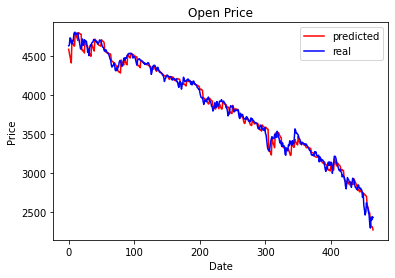

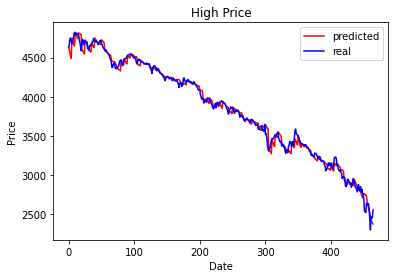

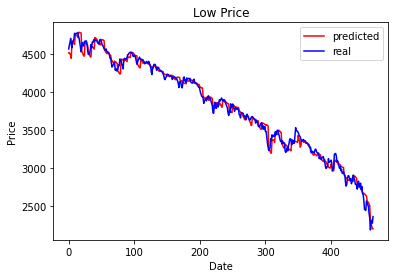

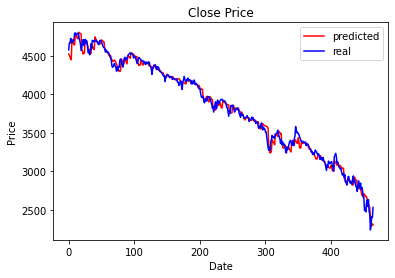

In [130]:
for i in range(columns):
    length = len(display_preds[i])
    plt.plot(range(length), display_preds[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), display_output[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()